# 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Activity_Recognition/training

/content/drive/MyDrive/Activity_Recognition/training


In [ ]:
#!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r yolov5/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'yolov5/requirements.txt'


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
random.seed(108)

In [ ]:
import torch
#파이토치 버전 확인, cuda device properties 확인
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 2.0.0+cu118 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


# 학습 시작

In [ ]:
%cd /content/drive/MyDrive/Activity_Recognition/yolov5

/content/drive/MyDrive/Activity_Recognition/yolov5


In [ ]:
!python train.py --img 1280 --batch 16 --epochs 15 --data /content/drive/MyDrive/Activity_Recognition/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name results

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/drive/MyDrive/Activity_Recognition/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1

In [ ]:
#학습 완료된 후에 tensorboard 통해 로그 확인
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Activity_Recognition/yolov5/runs/train/exp/

검증하기

In [ ]:
!python val.py --data /content/drive/MyDrive/Activity_Recognition/data.yaml --img 1280 --weights /content/drive/MyDrive/Activity_Recognition/yolov5/runs/train/results/weights/best.pt

예측하기

In [ ]:
!python detect.py --weights /content/drive/MyDrive/Activity_Recognition/yolov5/runs/train/results/weights/best.pt --img 1280 --conf 0.5 --source /content/drive/MyDrive/Activity_Recognition/test_img.jpg

# 데이터 Yolov5 포맷으로 만들기

In [ ]:
!ls

500_except_dataset.csv	    labels		    training
bbox_health_yoga.csv	    predefined_classes.txt  train_small.csv
box_health_yoga.csv	    requirements.txt	    transformed_image.jpg
box_health_yoga_train.csv   test_img.jpg	    validation
data.yaml		    train_200.csv	    yoga_validation
health_yoga_validation.csv  train_200_notnull.csv   yolov5
images			    train_500.csv
labeling		    train_500_notnull.csv


In [ ]:
def extract_info_dict(line):
  info_dict = {}
  info_dict['bboxes']=[]
  bbox = dict(category = line['label'] , xmin = line['xmin'], ymin = line['ymin'], xmax=line['xmax'], ymax =line['ymax'])
  info_dict['bboxes'].append(bbox)
  info_dict['filename']=line['image']
  info_dict['image_size']=(2800,2100)
  return info_dict

In [ ]:
%cd /content/drive/MyDrive/Activity_Recognition/

/content/drive/MyDrive/Activity_Recognition


In [ ]:
def convert_to_yolov5(info_dict):
  print_buffer = []
  for b in info_dict['bboxes']:
    try:
      class_id = b['category']
    except Exception as e:
      print(e)
    
    b_center_x = (b["xmin"] + b["xmax"])/2
    b_center_y = (b['ymin']+ b['ymax']) /2
    b_width    = (b["xmax"]-b["xmin"])
    b_height   = (b["ymax"]-b["ymin"])
    

    image_w, image_h = info_dict['image_size']
    b_center_x /= image_w
    b_center_y /= image_h
    b_width    /= image_w
    b_height   /= image_h

    print_buffer.append("{} {:.3f} {:.3f} {:3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
  imagename = info_dict['filename']
  filename = info_dict['filename'].replace("jpg", "txt").replace("TS_헬스_요가/", "").replace("TS_의약품_의료용품/", "").replace("TS_당구장/", "").replace("TS_캠핑용품/", "")
  print(filename)
  save_file_name = os.path.join("/content/drive/MyDrive/Activity_Recognition/labels/train", filename)
  #move_files_to_folder(imagename, '/content/drive/MyDrive/Activity_Recognition/images/train')
  print("\n".join(print_buffer), file = open(save_file_name, "w"))

In [ ]:
# df 적용 (df)
from ast import literal_eval 
df = pd.read_csv("training/training_labels_5_all.csv",  converters = {"label" : literal_eval, "xmin": literal_eval,  "xmax": literal_eval,  "ymin": literal_eval,  "ymax": literal_eval})

In [ ]:
df

,Unnamed: 0,image,xmin,ymin,xmax,ymax,label
0,0,TS_헬스_요가/1477113_605.jpg,1682.000000,1182.000000,1815.000000,1228.000000,291
1,1,TS_헬스_요가/2072307_605.jpg,358.000000,166.000000,434.000000,265.000000,298
2,2,TS_헬스_요가/1852047_605.jpg,1485.000000,1201.000000,1655.000000,1352.000000,285
3,3,TS_헬스_요가/1681012_605.jpg,1331.000000,985.000000,1448.000000,1120.000000,292
4,4,TS_헬스_요가/1420024_605.jpg,640.000000,1397.000000,780.000000,1457.000000,291
...,...,...,...,...,...,...,...
81677,81677,TS_헬스_요가/2098831_605_transformed850.jpg,1045.688690,43.258427,1152.295633,1427.528090,286
81678,81678,TS_헬스_요가/2099658_605_transformed851.jpg,1762.761303,255.571848,1844.433641,1317.888563,286
81679,81679,TS_헬스_요가/2098976_605_transformed852.jpg,1829.633350,424.508050,1894.324460,1085.688730,286
81680,81680,TS_헬스_요가/2098903_605_transformed853.jpg,1763.585952,1260.347682,1843.807763,1856.622517,286


In [ ]:
a = [560,
      517,    
      511,    
      527,  
      521,
      512,   
      516,   
      526,   
      475,    
      525,    
      490,  
      518,    
      476,    
      562,    
      288,    
      484,    
      530,    
      294,    
      522,    
      482,    
      520,    
      492,    
      524,    
      295,    
      483,    
      489,    
      487,    
      291,    
      477,    
      285,    
      523,    
      297,    
      491,    
      287,    
      293,    
      514,    
      292,    
      563,    
      290,    
      529,    
      481,    
      298,    
      564,    
      286,   
      289,    
      478,    
      474,    
      480,    
      513,    
      515,    
      479,    
      486]

b = np.arange(0, len(a))
for i in range(len(a)):
  df.loc[(df['label'] == a[i]), 'label'] = b[i]

In [ ]:
df

,Unnamed: 0,image,xmin,ymin,xmax,ymax,label
0,0,TS_헬스_요가/1477113_605.jpg,1682.000000,1182.000000,1815.000000,1228.000000,27
1,1,TS_헬스_요가/2072307_605.jpg,358.000000,166.000000,434.000000,265.000000,41
2,2,TS_헬스_요가/1852047_605.jpg,1485.000000,1201.000000,1655.000000,1352.000000,29
3,3,TS_헬스_요가/1681012_605.jpg,1331.000000,985.000000,1448.000000,1120.000000,36
4,4,TS_헬스_요가/1420024_605.jpg,640.000000,1397.000000,780.000000,1457.000000,27
...,...,...,...,...,...,...,...
81677,81677,TS_헬스_요가/2098831_605_transformed850.jpg,1045.688690,43.258427,1152.295633,1427.528090,43
81678,81678,TS_헬스_요가/2099658_605_transformed851.jpg,1762.761303,255.571848,1844.433641,1317.888563,43
81679,81679,TS_헬스_요가/2098976_605_transformed852.jpg,1829.633350,424.508050,1894.324460,1085.688730,43
81680,81680,TS_헬스_요가/2098903_605_transformed853.jpg,1763.585952,1260.347682,1843.807763,1856.622517,43


In [ ]:
for i, r in df.iterrows():
  if r['image'][:4]=='TS_ㅈ': #주방_다이닝룸 제거
    print(r)
    df.drop([i], axis=0,inplace = True)

In [ ]:
def extract_info_dict2(duplist):
  info_dict = {}
  info_dict['bboxes']=[]
  for i, d in duplist.iterrows():
    bbox = dict(category = d['label'] , xmin = d['xmin'], ymin = d['ymin'], xmax=d['xmax'], ymax =d['ymax'])
    info_dict['bboxes'].append(bbox)
    info_dict['filename']=d['image']
    info_dict['image_size']=(2800,2100)
  return info_dict

In [ ]:
#중복확인
dup = df.duplicated(['image'], keep='first')
dup = pd.DataFrame(dup)
s =[]
for ind,i in dup.iterrows():
  if i.bool()==True:
    s.append(ind)

dd = []
for j in s:
  a = []
  a.append(j)
  for k in s:
    if j==k:
      pass
    elif df['image'].iloc[j]==df['image'].iloc[k]:
      a.append(k)
  dd.append(a)

duplist = []
for d in dd:
  if len(d)>1:
    duplist.append(d)
duplist

[[402, 403],
 [403, 402],
 [955, 956],
 [956, 955],
 [1304, 1305],
 [1305, 1304],
 [1404, 1405],
 [1405, 1404],
 [1578, 1579],
 [1579, 1578],
 [2129, 2130],
 [2130, 2129],
 [2563, 2564],
 [2564, 2563],
 [2687, 2688],
 [2688, 2687],
 [2991, 2992, 2993],
 [2992, 2991, 2993],
 [2993, 2991, 2992],
 [3146, 3147],
 [3147, 3146],
 [3782, 3783, 3784],
 [3783, 3782, 3784],
 [3784, 3782, 3783],
 [4053, 4054, 4055, 4056],
 [4054, 4053, 4055, 4056],
 [4055, 4053, 4054, 4056],
 [4056, 4053, 4054, 4055],
 [4161, 4162],
 [4162, 4161],
 [4251, 4252],
 [4252, 4251],
 [4894, 4895],
 [4895, 4894],
 [5130, 5131, 5132],
 [5131, 5130, 5132],
 [5132, 5130, 5131],
 [5218, 5219],
 [5219, 5218],
 [5345, 5346],
 [5346, 5345],
 [5785, 5786],
 [5786, 5785],
 [6455, 6456],
 [6456, 6455],
 [7650, 7651],
 [7651, 7650],
 [8769, 8770],
 [8770, 8769],
 [8853, 8854],
 [8854, 8853],
 [8925, 8926, 8927],
 [8926, 8925, 8927],
 [8927, 8925, 8926],
 [8985, 8986],
 [8986, 8985],
 [9129, 9130],
 [9130, 9129],
 [9579, 9580, 9581

In [ ]:
duplists = list(set([tuple(set(duplist)) for duplist in duplist]))

In [ ]:
duplists

[(51304, 51302, 51303),
 (31344, 31343),
 (47981, 47982),
 (46512, 46510, 46511),
 (46848, 46849),
 (30792, 30793, 30791),
 (66832, 66833, 66834, 66831),
 (32172, 32173, 32174),
 (67636, 67637),
 (45805, 45806, 45807),
 (42204, 42205, 42206, 42207),
 (66235, 66236, 66237, 66238),
 (42312, 42313, 42314),
 (50222, 50223),
 (54362, 54363),
 (31096, 31097),
 (35236, 35237),
 (57557, 57558, 57559),
 (61289, 61290),
 (62552, 62553, 62554, 62555, 62556, 62557),
 (64102, 64103),
 (65461, 65462),
 (66310, 66311),
 (38612, 38613, 38614),
 (64832, 64833, 64834, 64835, 64836),
 (61776, 61774, 61775),
 (59384, 59385),
 (34438, 34439),
 (65740, 65741, 65742),
 (67144, 67145, 67146),
 (61409, 61410, 61411, 61412),
 (30019, 30020, 30021, 30022),
 (67476, 67477),
 (63120, 63121, 63118, 63119),
 (26440, 26439),
 (62153, 62154),
 (33513, 33514, 33515, 33516),
 (67234, 67235, 67236),
 (67027, 67028, 67029),
 (43908, 43909),
 (61876, 61877, 61878),
 (59176, 59175),
 (62488, 62489),
 (29501, 29502),
 (60827

In [ ]:
#중복 이미지 갖는 경우 txt 변환
for d in duplists:
  con = list(d)
  dupdf = df.iloc[con]
  a = extract_info_dict2(dupdf)
  print(a)
  convert_to_yolov5(a)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
{'bboxes': [{'category': 0, 'xmin': 1406.0, 'ymin': 578.0, 'xmax': 1514.0, 'ymax': 689.0}, {'category': 0, 'xmin': 1062.0, 'ymin': 51.0, 'xmax': 1140.0, 'ymax': 136.0}, {'category': 0, 'xmin': 686.0, 'ymin': 40.0, 'xmax': 767.0, 'ymax': 123.0}], 'filename': 'TS_당구장/2235614_595.jpg', 'image_size': (2800, 2100)}
2235614_595.txt
{'bboxes': [{'category': 0, 'xmin': 957.0, 'ymin': 860.0, 'xmax': 985.0, 'ymax': 886.0}, {'category': 0, 'xmin': 1020.0, 'ymin': 757.0, 'xmax': 1042.0, 'ymax': 781.0}], 'filename': 'TS_당구장/2203515_595.jpg', 'image_size': (2800, 2100)}
2203515_595.txt
{'bboxes': [{'category': 2, 'xmin': 1148.0, 'ymin': 819.0, 'xmax': 1230.0, 'ymax': 945.0}, {'category': 2, 'xmin': 1521.0, 'ymin': 777.0, 'xmax': 1651.0, 'ymax': 871.0}], 'filename': 'TS_의약품_의료용품/1036666_623.jpg', 'image_size': (2800, 2100)}
1036666_623.txt
{'bboxes': [{'category': 3, 'xmin': 1218.0, 'ymin': 976.0, 'xmax': 1298.0, 'ymax': 1138.0}, {'category': 3

In [ ]:
#중복 이미지를 갖는 경우를 제외한다. 
df = df.drop_duplicates(['image'])

In [ ]:
#하나하나 row에 적용한다.
for index, row in df.iterrows():
  convert_to_yolov5(extract_info_dict(row))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1868113_605_transformed.txt
1829352_605_transformed.txt
1869727_605_transformed.txt
1830608_605_transformed.txt
1736582_605_transformed.txt
1829458_605_transformed.txt
1830645_605_transformed.txt
1885778_605_transformed.txt
1441170_605_transformed.txt
1829252_605_transformed.txt
1736431_605_transformed.txt
1885789_605_transformed.txt
2124755_605_transformed.txt
1796108_605_transformed.txt
1829326_605_transformed.txt
1644348_605_transformed.txt
1830749_605_transformed.txt
1867831_605_transformed.txt
1832081_605_transformed.txt
1885701_605_transformed.txt
1886660_605_transformed.txt
1736622_605_transformed.txt
1830740_605_transformed.txt
1870203_605_transformed.txt
1736464_605_transformed.txt
1886693_605_transformed.txt
1830844_605_transformed.txt
1885641_605_transformed.txt
1867940_605_transformed.txt
1443244_605_transformed.txt
1885952_605_transformed.txt
1867951_605_transformed.txt
1868527_605_transformed.txt
1831923_605_transformed.txt
1870185_605_

In [ ]:
annotations = [x for x in os.listdir('/content/drive/MyDrive/Activity_Recognition/labels/train') if x[-3:] == "txt"]

In [ ]:
print("annotation data: ", len(annotations))

annotation data:  66001


# 이미지 데이터 옮기기

In [ ]:
def file_to_folder(file, destination_folder):
  shutil.move(file, destination_folder)

In [ ]:
import os

#중복 이미지를 갖는 경우를 제외한다. 
df = df.drop_duplicates(['image'], keep = "first")



folder = ["TS_헬스_요가", "TS_의약품_의료용품" ,"TS_당구장", "TS_캠핑용품"] #training/images안에 있는 폴더들 불러오기 (4개만 우선적으로 진행)
for i in folder:
  path = os.path.join('/content/drive/MyDrive/Activity_Recognition/training/images', i) #폴더 절대경로 지정
  images = [x for x in os.listdir(path) if x[-3:] == "jpg"] #폴더 안에 있는 jpg파일 불러오기
  for i, j in df.iterrows(): #df 파일 한줄씩 불러오기
    filename = j['image'].replace("TS_헬스_요가/", "").replace("TS_의약품_의료용품/", "").replace("TS_당구장/", "").replace("TS_캠핑용품/", "") #이미지 이름 앞에 폴더 경로 떼기
    if filename in images: #만약 df안에 있는 이미지 이름이 해당 폴더 안에 있으면
      file_to_folder(filename, '/content/drive/MyDrive/Activity_Recognition/images/train') #파일 images/train으로 옮기기

# 바꾼 annotation 실험

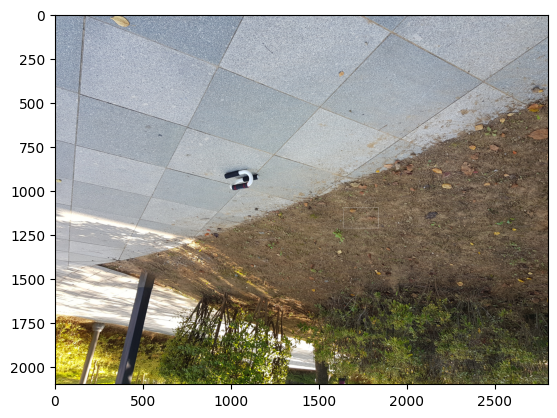

In [ ]:
random.seed(0)
#class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), {"omg": obj_cls})
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
with open('TS_annotation_yolo/1851968_605.txt', "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = 'TS_image/1851968_605.jpg'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# 데이터 분할

In [ ]:
# Read images and annotations
i_l= [x for x in os.listdir('TS_image')]
annotations = [os.path.join('TS_annotation_yolo', x) for x in os.listdir('TS_annotation_yolo') if x[-3:] == "txt"]
a_l = [x for x in os.listdir('TS_annotation_yolo') if x[-3:] == "txt"]
i_l.sort()
a_l.sort()
print(a_l)
print(i_l)
images = []
for i in i_l:
  for j in a_l:
    if i[:-3]==j[:-3]:
      images.append(os.path.join('TS_image', i))

print(images)
annotations.sort()
images.sort()
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

['1001398_605.txt', '1036825_605.txt', '1037259_605.txt', '1037274_605.txt', '1037289_605.txt', '1037315_605.txt', '1037329_605.txt', '1051937_605.txt', '1063984_605.txt', '1066140_605.txt', '1066147_605.txt', '1066152_605.txt', '1066197_605.txt', '1066203_605.txt', '1066230_605.txt', '1066260_605.txt', '1073561_605.txt', '1073562_605.txt', '1073563_605.txt', '1073564_605.txt', '1078203_605.txt', '1081951_605.txt', '1115704_605.txt', '1115718_605.txt', '1115760_605.txt', '1128803_605.txt', '1157675_605.txt', '1157677_605.txt', '1157681_605.txt', '1163259_605.txt', '1163264_605.txt', '1163265_605.txt', '1163266_605.txt', '1163268_605.txt', '1163273_605.txt', '1163276_605.txt', '1163279_605.txt', '1168781_605.txt', '1168789_605.txt', '1168795_605.txt', '1168798_605.txt', '1168842_605.txt', '1170052_605.txt', '1170080_605.txt', '1170090_605.txt', '1170396_605.txt', '1178474_605.txt', '1178491_605.txt', '1184573_605.txt', '1190351_605.txt', '1190445_605.txt', '1191702_605.txt', '1191711_60

In [ ]:
os.makedirs('images/train')
os.makedirs('images/val')
os.makedirs('images/test')
os.makedirs('labels/train')
os.makedirs('labels/val')
os.makedirs('labels/test')

# 파일 옮기기

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except Exception as e:
            print(f)
            print(e)

In [ ]:
#총 데이터 개수 확인
val_images = [x for x in os.listdir('images/val')]
val_labels = [x for x in os.listdir('labels/val')]
val_images.sort()
val_labels.sort()
test_images = [x for x in os.listdir('images/test')]
test_labels = [x for x in os.listdir('labels/test')]
test_images.sort()
test_labels.sort()
train_images = [x for x in os.listdir('images/train')]
train_labels = [x for x in os.listdir('labels/train')]
train_images.sort()
train_labels.sort()

for i, j in zip(val_images, val_labels):
  if i[:-3]==j[:-3]:
    pass
  else:
    print("error", i, j)

for i, j in zip(test_images, test_labels):
  if i[:-3]==j[:-3]:
    pass
  else:
    print("error", i, j)

for i, j in zip(train_images, train_labels):
  if i[:-3]==j[:-3]:
    pass
  else:
    print("error", i, j)

print(len(val_images))
print(len(val_labels))
print(len(test_images))
print(len(test_labels))
print(len(train_images))
print(len(train_labels))

686
686
686
686
3140
3140


# 노쓸모 코드
## 파일 분할하고 디렉토리에 옮겨담기

In [ ]:
annotations = [x for x in os.listdir('TS_annotation_yolo') if x[-3:] == "txt"]
test = 'images/test'
val = 'images/val'

for i in annotations:
  i = i.replace("txt", "jpg")
  file_name_t = os.path.join(test, i)
  print(file_name_t)
  file_name_v = os.path.join(val, i)

  if os.path.isfile(file_name_t):
    i = i.replace("jpg", "txt")
    file_to_folder(os.path.join('TS_annotation_yolo', i), 'labels/test/')

  if os.path.isfile(file_name_v):
    i = i.replace("jpg", "txt")
    file_to_folder(os.path.join('TS_annotation_yolo', i), 'labels/val/')

In [ ]:
# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

In [ ]:
k = [x for x in os.listdir('images/train')]
for i in k:
  file_to_folder(os.path.join('images/train', i), 'TS_image')

In [ ]:
#파일 안옮겨졌을 때 옮길 코드
annotations = [x for x in os.listdir('labels/train') if x[-3:] == "txt"]
train = 'TS_image'
for i in annotations:
  i = i.replace("txt", "jpg")
  file_name_t = os.path.join(train, i)
  print(file_name_t)
  if os.path.isfile(file_name_t):
    file_to_folder(os.path.join('TS_image', i), 'images/train')

TS_image/1954578_605.jpg
TS_image/1942283_605.jpg
TS_image/1942026_605.jpg
TS_image/1943889_605.jpg
TS_image/1941650_605.jpg
TS_image/1943385_605.jpg
TS_image/1942892_605.jpg
TS_image/1967155_605.jpg
TS_image/1943325_605.jpg
TS_image/1943844_605.jpg
TS_image/1951040_605.jpg
TS_image/1948463_605.jpg
TS_image/1966161_605.jpg
TS_image/1954573_605.jpg
TS_image/1958991_605.jpg
TS_image/1959190_605.jpg
TS_image/1971459_605.jpg
TS_image/1581179_605.jpg
TS_image/1942146_605.jpg
TS_image/1948661_605.jpg
TS_image/1967162_605.jpg
TS_image/1954563_605.jpg
TS_image/1966633_605.jpg
TS_image/1958976_605.jpg
TS_image/1951018_605.jpg
TS_image/1959135_605.jpg
TS_image/1943906_605.jpg
TS_image/1942022_605.jpg
TS_image/1941969_605.jpg
TS_image/1966715_605.jpg
TS_image/1951042_605.jpg
TS_image/1942125_605.jpg
TS_image/1948456_605.jpg
TS_image/1948502_605.jpg
TS_image/1942516_605.jpg
TS_image/1943367_605.jpg
TS_image/1954502_605.jpg
TS_image/1959019_605.jpg
TS_image/1881480_605.jpg
TS_image/1961878_605.jpg


In [ ]:
print(annotations)

['1954578_605.txt', '1942283_605.txt', '1942026_605.txt', '1943889_605.txt', '1941650_605.txt', '1943385_605.txt', '1942892_605.txt', '1967155_605.txt', '1943325_605.txt', '1943844_605.txt', '1951040_605.txt', '1948463_605.txt', '1966161_605.txt', '1954573_605.txt', '1958991_605.txt', '1959190_605.txt', '1971459_605.txt', '1581179_605.txt', '1942146_605.txt', '1948661_605.txt', '1967162_605.txt', '1954563_605.txt', '1966633_605.txt', '1958976_605.txt', '1951018_605.txt', '1959135_605.txt', '1943906_605.txt', '1942022_605.txt', '1941969_605.txt', '1966715_605.txt', '1951042_605.txt', '1942125_605.txt', '1948456_605.txt', '1948502_605.txt', '1942516_605.txt', '1943367_605.txt', '1954502_605.txt', '1959019_605.txt', '1881480_605.txt', '1961878_605.txt', '1882102_605.txt', '1961913_605.txt', '2192841_605.txt', '1961898_605.txt', '1881171_605.txt', '1966649_605.txt', '1879010_605.txt', '1961654_605.txt', '2191797_605.txt', '1970542_605.txt', '2021043_605.txt', '2191905_605.txt', '1878945_60